Here is Aleks Afanaseva's notebook for final task "How to win a Data Science competition. I used mainly feature engineering to get my result. Most useful feature was sold_total - total number of solded item in the shop in previous month. My public and private LB scores are: 0.990252 and 0.997702

* [Import section](#Import-section)
* [Load and observe the data](#Load-and-observe-the-data)
* [Extracting some features from additional tables](#Extracting-some-features-from-additional-tables)
    - [Shops](##Shops)
        - [Merge duplicate shops](###Merge-duplicate-shops)
        - [Extraction city name](###Extraction-city-name)
    - [Items](##Items)
* [Getting same format for train and test sets](#Getting-same-format-for-train-and-test-sets)
* [Feature engineering](#Feature-engineering)
    - [Previous month targets](##Previous-month-targets)
    - [Merge with additional data from other tables](##Merge-with-additional-data-from-other-tables)
    - [Month as a feature](##Month-as-a-feature)
    - [Category encoding](##Category-encoding)
    - [Feature list for model](##Feature-list-for-model)
* [Work with outliers](#Work-with-outliers)    
* [Model training](#Model-training)
    - [Some visualizations for model](##Some-visualizations-for-model)
* [Getting final prediction](#getting-final-pred)

# Import section

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re

from lightgbm import LGBMRegressor
import lightgbm

from sklearn.model_selection import learning_curve,train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from itertools import product

import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (20,4)

import seaborn as sns
%matplotlib inline


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

 # Load and observe the data

In [2]:
folder = '/kaggle/input/competitive-data-science-predict-future-sales/'
#folder = './files/'

train = pd.read_csv(folder+'sales_train.csv')
shops = pd.read_csv(folder+'shops.csv')
items = pd.read_csv(folder+'items.csv')
itemcat = pd.read_csv(folder+'item_categories.csv')
test = pd.read_csv(folder+'test.csv')

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
itemcat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


Target related value is item price, so I want to see at distribution of the prices and work with outliers just rigth here

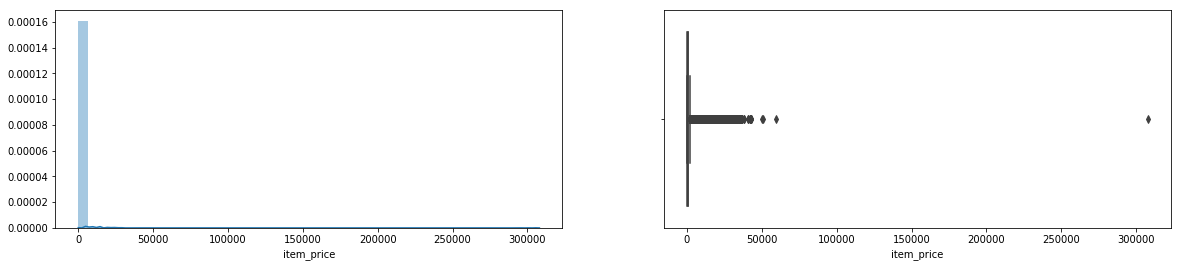

In [7]:
fig, ax = plt.subplots(1,2,figsize = (20,4))
sns.distplot(train.item_price, ax = ax[0])
sns.boxplot(train.item_price, ax = ax[1])

We have a long tail in the variable, so let's see the bigger values:

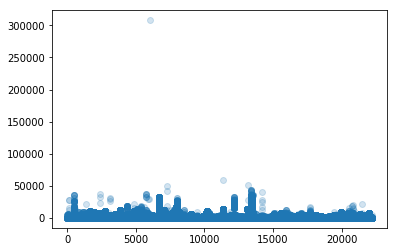

In [8]:
plt.scatter(x = train.item_id,y = train.item_price, alpha = .2)

In [9]:
train[['item_id','item_price','shop_id']].drop_duplicates().sort_values(by = 'item_price',ascending = False).head(3)

,item_id,item_price,shop_id
1163158,6066,307980.0,12
885138,11365,59200.0,12
1488135,13199,50999.0,25


In [10]:
items[items.item_id==6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [11]:
test[test.item_id==6066]

,ID,shop_id,item_id


In [12]:
train[train.item_id==6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [13]:
train.drop(train[train.item_id==6066].index, inplace = True)

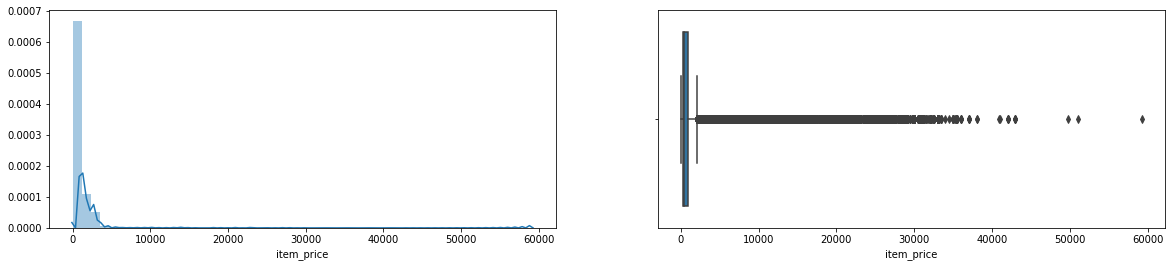

In [14]:
fig, ax = plt.subplots(1,2,figsize = (20,4))
sns.distplot(train.item_price, ax = ax[0])
sns.boxplot(train.item_price, ax = ax[1])

In [15]:
expensive = train[train.item_price>10000][['item_id']].drop_duplicates()
test_expensive = expensive.merge(test[['item_id']].drop_duplicates(), on = 'item_id', how = 'inner')
print('There are {} items expensiver than 10000 in train.\n{} of them are in test'.format(
len(expensive),len(test_expensive)))


There are 178 items expensiver than 10000 in train.
34 of them are in test


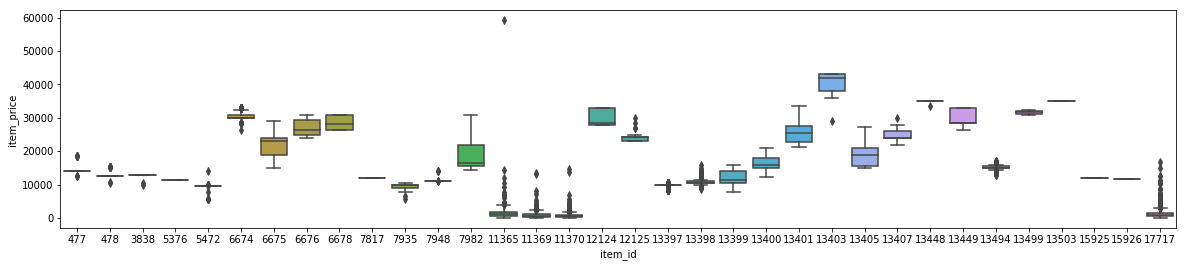

In [16]:
fig, ax = plt.subplots(1,1,figsize = (20,4))
sns.boxplot(data = train[['item_id','item_price']].merge(test_expensive, on = 'item_id', how = 'inner'),
            x = 'item_id',y = 'item_price', ax = ax)


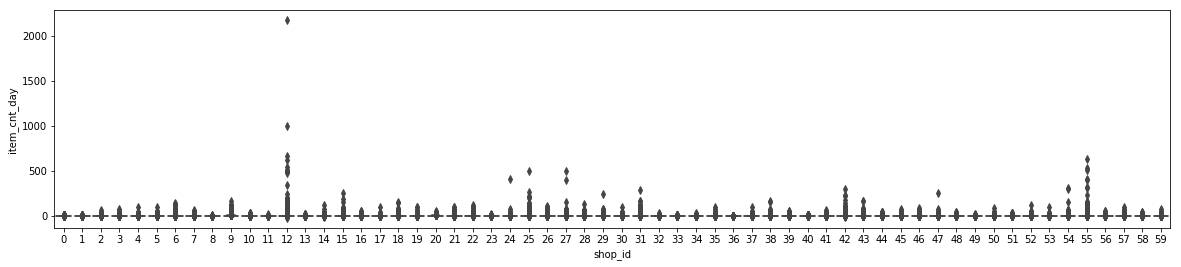

In [17]:
fig,ax = plt.subplots(figsize = (20,4))
sns.boxplot(data = train[['shop_id','item_cnt_day']],
            x = 'shop_id',y = 'item_cnt_day', ax = ax)

In [18]:
train[train.item_id==11365].merge(items, on = 'item_id',how = 'left').sort_values(by = 'item_price',ascending = False).head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
87,17.09.2013,8,12,11365,59200.0,1.0,Доставка (EMS),9
26,05.03.2013,2,12,11365,14530.0,1.0,Доставка (EMS),9
92,23.09.2013,8,12,11365,11880.0,1.0,Доставка (EMS),9
39,12.03.2013,2,12,11365,10540.0,1.0,Доставка (EMS),9
88,28.09.2013,8,12,11365,9370.0,1.0,Доставка (EMS),9


In [19]:
items[items.item_category_id==9]

,item_name,item_id,item_category_id
11364,Доставка (DHL),11364,9
11365,Доставка (EMS),11365,9
11366,Доставка (Ваш Почтальон),11366,9
11367,Доставка (Клео-Логистик),11367,9
11368,Доставка (Курьер),11368,9
11369,Доставка (Почта),11369,9
11370,Доставка (по Москве),11370,9
11371,Доставка Альтернативная (по Москве),11371,9
11372,Доставка до постомата (PickPoint),11372,9
11373,Доставка до пункта выдачи (Boxberry),11373,9


In [20]:
train = train.merge(items, on = 'item_id', how = 'left')

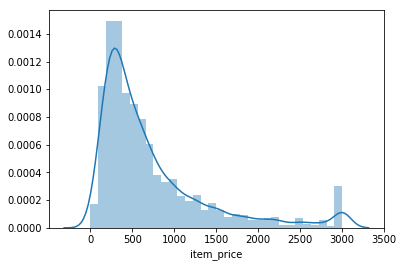

In [21]:
sns.distplot(train[train.item_category_id==9].item_price.clip(0,3000))

In [22]:
np.percentile(train[train.item_category_id==9].item_price,99.9)

14380.24000000035

In [23]:
shops[shops.shop_id==12]

,shop_name,shop_id
12,Интернет-магазин ЧС,12


# Extracting some features from additional tables

## Shops

In [24]:
# for every text column: deleting spec symbols and extra spaces, lower case
def str_clean(x):
    return re.sub(re.compile('\W'),' ',x.lower()).strip()
shops['shop_name'] = shops['shop_name'].apply(str_clean)
itemcat['item_category_name'] = itemcat['item_category_name'].apply(str_clean)

In [25]:
items['item_name'] = items['item_name'].apply(str_clean)

### Merge duplicate shops
We have some duplicates in shop list, so I want to merge them in on shop. There are pairs 0 and 57, 1 and 58, 39 and 40, 10 and 11

In [26]:
#fix duplicates:
duplicate_shops = {57:0,58:1,40:39,11:10}
def fix_shop_id(x):
    if x not in duplicate_shops.keys():
        return x
    return duplicate_shops[x]
train['shop_id'] = train['shop_id'].apply(fix_shop_id)
test['shop_id'] = test['shop_id'].apply(fix_shop_id)
shops.drop(shops[shops.shop_id.isin(duplicate_shops.keys())].index,inplace = True)

### Extraction city name

In [27]:
shops['city'] = shops.shop_name.apply(lambda x: x.split()[0])

Label encoding for cities:

In [28]:
le = LabelEncoder()
shops['city_id'] = le.fit_transform(shops['city'])

## Items
I want to use mean price for each item as a feature

In [29]:
#mean price for id:
prices = train.groupby(['item_id','shop_id','date_block_num'],as_index=False).agg(
    {
        'item_price':{'mean_price':'mean','price_std':'std','price_count':'count'},
        'item_cnt_day':{'sold_total':'sum'}
    }
).fillna(0)

In [30]:
prices.columns = ['item_id','shop_id','date_block_num','mean_price','price_std','price_count','sold_total']

In [31]:
prices['date_block_num']+=1

In [32]:
prices.head()

,item_id,shop_id,date_block_num,mean_price,price_std,price_count,sold_total
0,0,54,21,58.0,0.0,1,1.0
1,1,55,16,4490.0,0.0,2,2.0
2,1,55,19,4490.0,0.0,1,1.0
3,1,55,20,4490.0,0.0,1,1.0
4,1,55,21,4490.0,0.0,1,1.0


In [33]:
#prices['mean_price'] = prices['mean_price'].clip(0,np.percentile(prices.mean_price,99))

# Getting same format for train and test sets
Here I'll get a test-like format for train set. Afterwards, I'll merge all data in one table X and will process all data together. I will split it before training the model.

In [34]:
X = train.groupby(['date_block_num','shop_id','item_id'],as_index = False
                 ).item_cnt_day.sum()
X.rename(columns = {'item_cnt_day':'target'}, inplace=True)
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = [] 
for block_num in train['date_block_num'].unique():
    cur_shops = train[train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = train[train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
X = pd.merge(grid,X,how='left',on=index_cols).fillna(0)
#sort the data
X.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

In [35]:
X.head()

,shop_id,item_id,date_block_num,target
139255,0,19,0,0.0
141495,0,27,0,0.0
144968,0,28,0,0.0
142661,0,29,0,0.0
138947,0,32,0,6.0


In [36]:
shops[(shops.shop_id==55) |(shops.shop_id==12)]

,shop_name,shop_id,city,city_id
12,интернет магазин чс,12,интернет,7
55,цифровой склад 1с онлайн,55,цифровой,27


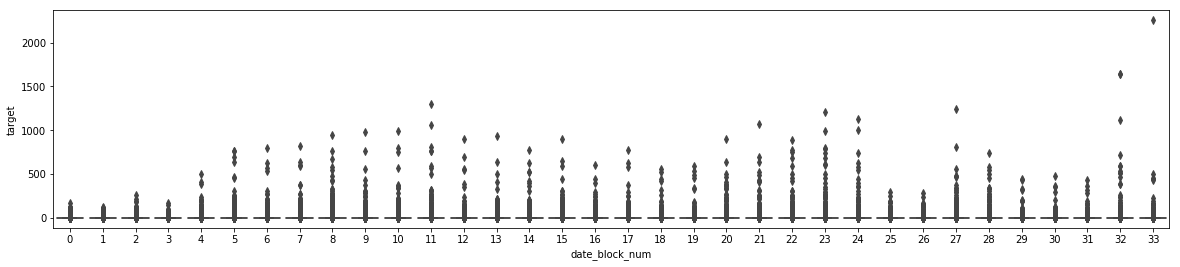

In [37]:
fig,ax = plt.subplots(figsize = (20,4))
sns.boxplot(x = 'date_block_num',y = 'target',data = X[X.target>0])

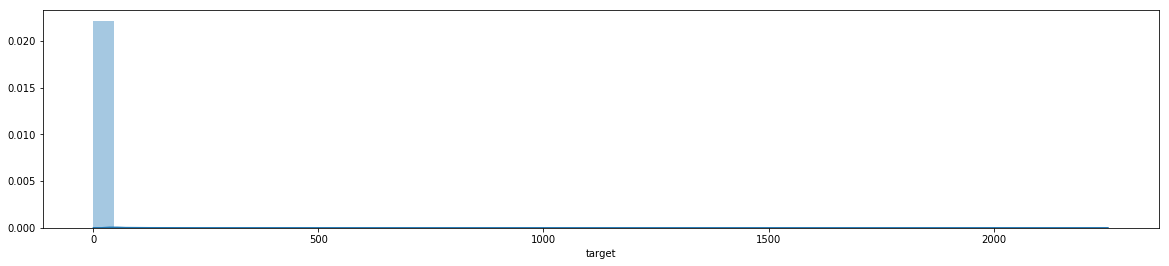

In [38]:
fit,ax=plt.subplots(figsize = (20,4))
sns.distplot(X[X.target>0].target)

# Feature engineering
## Previous month targets
I will get values for shop_id-item_id pair in previous 3 months

In [39]:
#previous months
X.sort_values(by = ['shop_id','item_id','date_block_num'],inplace=True)
month_ago = 3
for i in range(1, month_ago+1):
    colname = 'prev' + str(i)
    X[colname] = X.target.shift(i)
    mask1 = X.shop_id != X.shop_id.shift(i)  
    mask2 = X.item_id!= X.item_id.shift(i)
    mask = mask1|mask2
    X[colname][mask] = 0

#test_data prev columns forming:
train_columns = ['shop_id','item_id','target']+['prev'+str(i) for i in range(1,month_ago+1)]
test = test.merge(X[X.date_block_num==33][train_columns],on = ['shop_id','item_id'],how = 'left')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [40]:
test.rename(columns = {'prev3':'prev4','prev2':'prev3','prev1':'prev2','target':'prev1'}, inplace = True)
del test['prev'+str(month_ago+1)]


In [41]:
X_target = X.target.values

In [42]:
del X['target']

In [43]:
test['date_block_num']=34
X['ID'] = X.index

In [44]:
X = X.append(test)

## Merge with additional data from other tables

In [45]:
X = X.merge(items[['item_id','item_category_id', 'item_name']], on = 'item_id', how = 'left')
X = X.merge(shops[['shop_id','city_id','shop_name']], on = 'shop_id', how = 'left')

In [46]:
X = X.merge(itemcat, on = 'item_category_id', how = 'left')

In [47]:
X = X.merge(prices, on = ['item_id','shop_id','date_block_num'], how = 'left')

## Month as a feature


In [48]:
X['month'] = X['date_block_num']%12 + 1

## A little bit more features

In [49]:
# is it internet shop?
X['is_internet'] = X['shop_id'].apply(lambda x: 1 if x in [12,55] else 0)

# Some additional EDA here

I assume that items with huge sales are seasonable. So I want to show it up.

In [50]:
X['target_block_num'] = X['date_block_num']-1
X['target_month'] = X['target_block_num']%12+1

In [51]:
X[(~X.item_id.isin([20949]))&(~X.item_category_id.isin(['9']))].sort_values(
    by = 'prev1', ascending = False).head().T

,10203868,10223677,10351455,2247048,5144823
ID,9648042,8770437,7854238,7488972,5846876
date_block_num,28,25,22,21,16
item_id,3730,5917,19437,9242,8057
prev1,1242,1127,1074,904,903
prev2,0,50,0,9,0
prev3,0,3,0,8,0
shop_id,55,55,55,12,27
item_category_id,31,31,31,8,32
item_name,grand theft auto v pc цифровая версия,prototype 2 pc цифровая версия,средиземье тени мордора pc цифровая версия,билет игромир 2014 на один день отдельно ...,itunes 1500 руб
city_id,27,27,27,7,13


Obviously, there are a lot of bags in the good solded goods. But bags couldn't be a seasonal. And they don't have special category, so I want to create new feature - is bag.

In [52]:
X['is_bag'] = X.item_id.apply(lambda x: 1 if x == 20949 else 0)

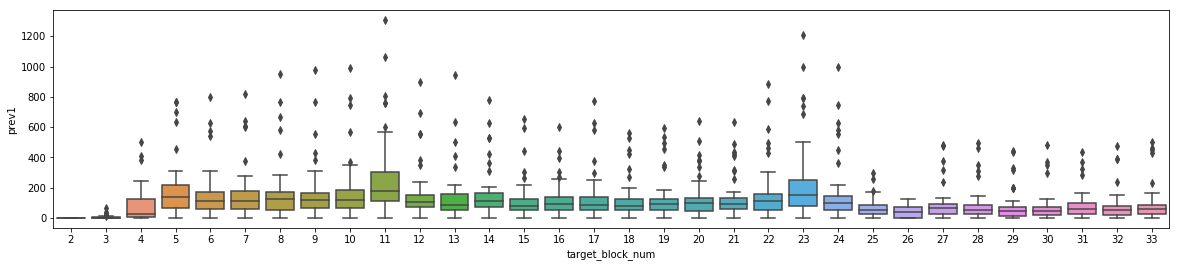

In [53]:
fig,ax = plt.subplots(figsize = (20,4))
sns.boxplot(data = X[X.is_bag==1], x = 'target_block_num',y = 'prev1')

### Delivery is only for shop_id==12!
proof is here

But PC games defenetly could have a peak after release. So. let's see. I will assume that the game has a peak if there is 1 or 2 peak months and there is zero months after. 

In [54]:
popular_games = X[(X.item_category_id==31)&(X.prev1>100)].sort_values(by = 'prev1', ascending = False).item_id.drop_duplicates().head(10).to_list()

In [55]:
popular_games

[3730, 5917, 19437, 3025, 19445, 19446, 4392, 1875, 2042, 3931]

In [56]:
game = 3730


In [57]:
X[X.item_id==game].groupby('target_block_num',as_index = False)['prev1'].sum()

,target_block_num,prev1
0,26,0.0
1,27,1242.0


3730 [0.7731014009535884, 0.8987934711608376, 0.8069246616921207]
5917 [0.6533271890137644, 0.8229461223527293, 0.8273868966437787]
19437 [0.637057705769429, 0.693304181768162, 0.8540991755662022]
3025 [0.693482063360475, 0.5466429957379686, 0.7738406527439693]
19445 [0.7104313432038998, 0.4438112184912335, 0.5661553007918629]
19446 [0.6107420788222797, 0.41024905426676106, 0.34068738411858357]
4392 [0.4046045085600732, 0.4087869166692251, 0.19770904265482428]
1875 [0.20318252506201007, 0.3792899232783168, 0.19223962501442876]
2042 [0.1017832854371783, 0.2883305528390939, 0.24364404529962175]
3931 [0.09234702929311903, 0.1623461438979033, 0.23210242498343797]


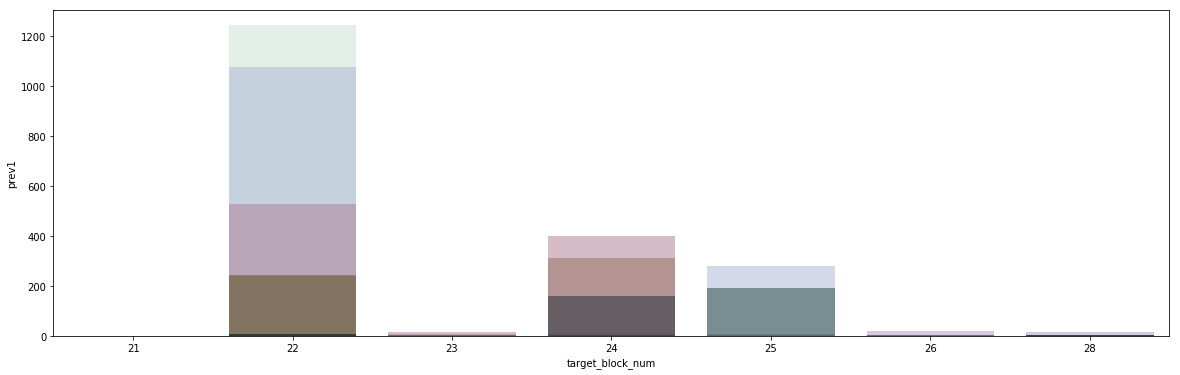

In [58]:
fig, ax = plt.subplots(figsize = (20,6))
for game, color in zip(popular_games,sns.cubehelix_palette(10,start=.5, rot=-1.75)):
    print(game,color)
    sns.barplot(x = 'target_block_num',y = 'prev1',
            data = X[X.item_id==game].groupby('target_block_num',as_index = False)['prev1'].sum(),
            color = color,
            alpha = .5, 
            label = 'game'
           )
    

In [59]:

X[X.prev1>100].item_id.nunique()

126

## Category encoding
I'll get values for previous month. It will mean value, median and standart deviation.

In [60]:
col = 'item_category_id'
for col in ['item_category_id','item_id','shop_id','city_id']:
    X = X.merge(
        X.groupby(col, as_index=False)['prev1'].agg({col+'_mean':'mean',col+'_median':'median',col+'_std':'std'}),
        on = col,
        how = 'left'
    )

## Feature list for model

In [61]:
ftr = [
    'month',
    'city_id',
    'item_id',
    'shop_id',
    'date_block_num',
    'prev1','prev2','prev3',
    'item_category_id',
    'mean_price',
    'price_count',
    'sold_total',
    'is_internet',
    'is_bag'
]

# Work with outliers
Target and previous months values will be cropped into (0,20) interval, another value will be cropped into interval from 0 to 99.9 percentile.

In [62]:
#clip for outliers
for i in [x for x in ftr if x not in ['prev1','prev2','prev3']]:
    X[i] = X[i].clip(0,np.percentile(X[i],99.9))

In [63]:
for i in ['prev1','prev2','prev3']:
    X[i] = X[i].clip(0,20)

# Model training
I'll use LightGBM regressor as fastest boosting tree model.

In [64]:
lgbm = LGBMRegressor(random_state = 42, 
                     max_depth = 8,
                     objective = 'rmse',
           
                    )

What amount of data is it better to use?

In [65]:
months = pd.DataFrame()
for m in range(32):
    lgbm.fit(X[(X.date_block_num>m)&(X.date_block_num<33)][ftr],
         X_target[X[(X.date_block_num>m)&(X.date_block_num<33)].index].clip(0,20))
    pred = lgbm.predict(X[X.date_block_num==33][ftr])
    months.loc[m,'score'] = mean_squared_error(
        pred.clip(0,20),X_target[X[X.date_block_num==33].index].clip(0,20))**0.5
    print(m,": ",months.loc[m,'score'])
    

0 :  0.9502158960251404
1 :  0.9474569791986577
2 :  0.945377136689564
3 :  0.9485758845641661
4 :  0.9486599797008729
5 :  0.9495537887675717
6 :  0.9456060411393789
7 :  0.9544914650074466
8 :  0.9500031804503977
9 :  0.9502515102165907
10 :  0.9512125787785265
11 :  0.9462408090533779
12 :  0.9469669045740003
13 :  0.9507982856964005
14 :  0.9504357912365728
15 :  0.9551098577671064
16 :  0.9469117472978511
17 :  0.9589149277769684
18 :  0.9542632285561424
19 :  0.9518967387585551
20 :  0.9546545004043635
21 :  0.9544255604626897
22 :  0.9671714914624833
23 :  0.9604444711654168
24 :  0.9656482709154143
25 :  0.9595642880533407
26 :  0.970536742968246
27 :  0.9612386924470135
28 :  0.9728563904898054
29 :  0.9794393210919954
30 :  0.9827331466083159
31 :  0.9940645339795441


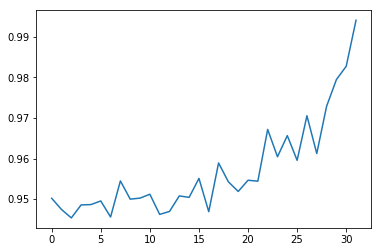

In [66]:
plt.plot(months)

In [67]:
begin_month = 10
lgbm.fit(X[(X.date_block_num>begin_month)&(X.date_block_num<33)][ftr],
         X_target[X[(X.date_block_num>begin_month)&(X.date_block_num<33)].index])
pred = lgbm.predict(X[X.date_block_num==33][ftr])
score = mean_squared_error(pred.clip(0,20),X_target[X[X.date_block_num==33].index].clip(0,20))**0.5
print(score)

1.0623786618063746


## Some visualizations for model

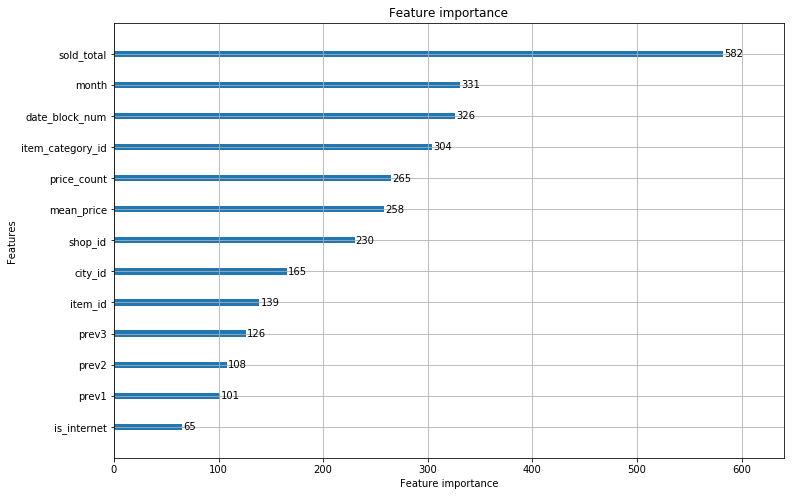

In [68]:
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize = (12,8))
plot_importance(lgbm, ax = ax)

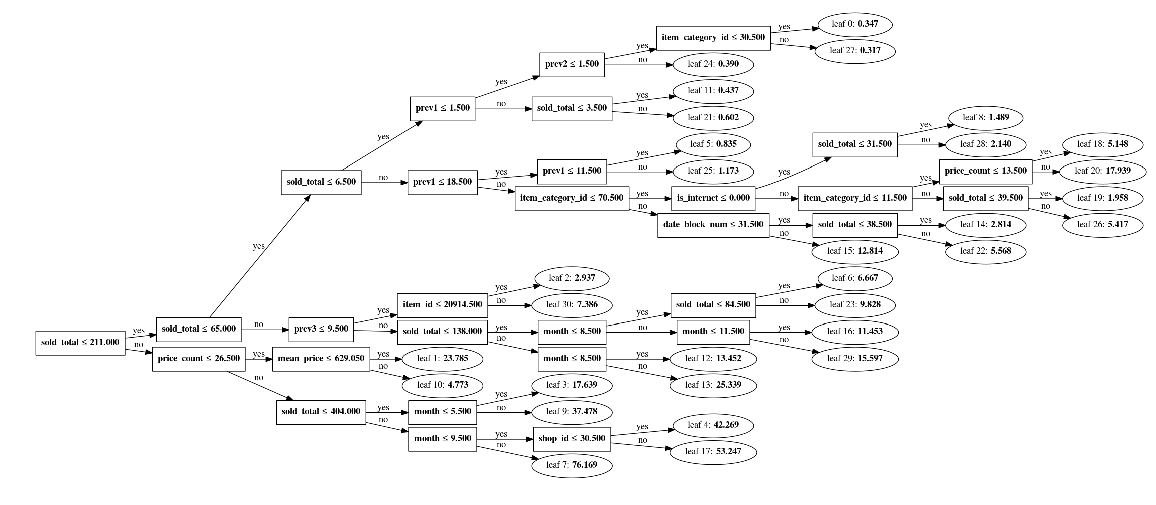

In [69]:
fig,ax = plt.subplots(figsize = (20,15))
lightgbm.plot_tree(lgbm, ax = ax)

# Getting final prediction

In [70]:
lgbm.fit(X[(X.date_block_num>begin_month)&(X.date_block_num<34)][ftr],
         X_target[X[(X.date_block_num>begin_month)&(X.date_block_num<34)].index].clip(0,20))
pred = lgbm.predict(X[X.date_block_num==34][ftr]).clip(0,20)
res = pd.DataFrame()
res['ID'] = test['ID']
res['item_cnt_month'] = pred


In [71]:
nt = test.merge(items[['item_id','item_category_id']], on = 'item_id',how = 'left')
res.loc[nt[(nt.item_category_id==9)&(nt.shop_id!=12)].index,'item_cnt_month'] = 0

In [72]:
res.to_csv('submission.csv', index = False)